In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.insert(0, '/home/rtandon32/ebm/pySuStaIn/sim/')

In [3]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cbook as cbook

import os

import pandas as pd

from simfuncs import *

from functools import partial, partialmethod
from kde_ebm.mixture_model import fit_all_gmm_models, fit_all_kde_models
from kde_ebm import plotting

import warnings
#warnings.filterwarnings("ignore",category=cbook.mplDeprecation)

from pySuStaIn.sEBMSustain import sEBMSustainData
from pySuStaIn.sEBMSustain import sEBMSustain
from pySuStaIn.ZscoreSustain  import ZscoreSustain
from pySuStaIn.MixtureSustain import MixtureSustain

import sklearn.model_selection

import pylab

In [4]:
N                       = 8         # number of biomarkers
M                       = 800       # number of observations ( e.g. subjects )
N_S_ground_truth        = 3         # number of ground truth subtypes
stage_sizes = [2,2,2,2]
# the fractions of the total number of subjects (M) belonging to each subtype
ground_truth_fractions = np.array([0.5, 0.30, 0.20])

#create some generic biomarker names
BiomarkerNames           = ['Biomarker ' + str(i) for i in range(N)]

#***************** parameters for SuStaIn-based inference of subtypes
use_parallel_startpoints = True

# number of starting points
N_startpoints           = 25
# maximum number of inferred subtypes - note that this could differ from N_S_ground_truth
N_S_max                 = 4
N_iterations_MCMC       = int(1e5)  #Generally recommend either 1e5 or 1e6 (the latter may be slow though) in practice

#labels for plotting are biomarker names
SuStaInLabels           = BiomarkerNames

# cross-validation
validate                = True
N_folds                 = 3         #Set low to speed things up here, but generally recommend 10 in practice

#either 'mixture_GMM' or 'mixture_KDE' or 'zscore'
sustainType             = 'mixture_GMM'

In [5]:
dataset_name            = 'sim7'
output_folder           = os.path.join(os.getcwd(), dataset_name + '_' + sustainType)
if not os.path.isdir(output_folder):
    os.mkdir(output_folder)

In [6]:
ground_truth_subj_ids   = list(np.arange(1, M+1).astype('str'))
ground_truth_sequences  = generate_random_mixture_sustain_model(N, N_S_ground_truth)

ground_truth_subtypes   = np.random.choice(range(N_S_ground_truth), M, replace=True, p=ground_truth_fractions).astype(int)

N_stages                = N

ground_truth_stages_control = np.zeros((int(np.round(M * 0.25)), 1))
ground_truth_stages_other   = np.random.randint(1, N_stages+1, (int(np.round(M * 0.75)), 1))
ground_truth_stages         = np.vstack((ground_truth_stages_control, ground_truth_stages_other)).astype(int)

data, data_denoised     = generate_data_mixture_sustain(ground_truth_subtypes, ground_truth_stages, ground_truth_sequences, sustainType)

/home/rtandon32/.conda/envs/sustain/lib/python3.9/site-packages/scipy/optimize/_optimize.py:404: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


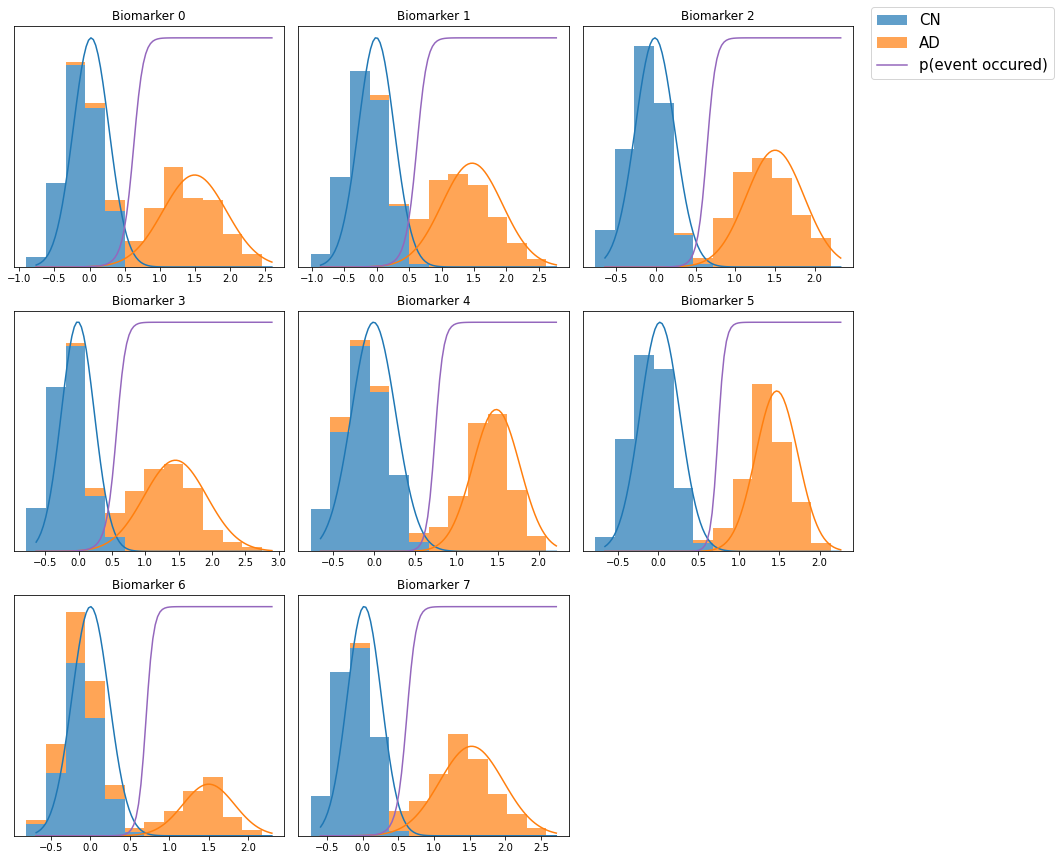

In [7]:
# choose which subjects will be cases and which will be controls
MIN_CASE_STAGE          = np.round((N + 1) * 0.8)
index_case              = np.where(ground_truth_stages >=  MIN_CASE_STAGE)[0]
index_control           = np.where(ground_truth_stages ==  0)[0]

labels                  = 2 * np.ones(data.shape[0], dtype=int)     # 2 - intermediate value, not used in mixture model fitting
labels[index_case]      = 1                                         # 1 - cases
labels[index_control]   = 0                                         # 0 - controls

data_case_control       = data[labels != 2, :]
labels_case_control     = labels[labels != 2]

if sustainType == "mixture_GMM":
    mixtures            = fit_all_gmm_models(data, labels)
elif sustainType == "mixture_KDE":
    mixtures            = fit_all_kde_models(data, labels)

fig, ax                 = plotting.mixture_model_grid(data_case_control, labels_case_control, mixtures, SuStaInLabels)#, plotting_font_size=20)
fig.show()
fig.savefig(os.path.join(output_folder, 'kde_fits.png'))

L_yes                   = np.zeros(data.shape)
L_no                    = np.zeros(data.shape)
for i in range(N):
    if sustainType == "mixture_GMM":
        L_no[:, i], L_yes[:, i] = mixtures[i].pdf(None, data[:, i])
    elif sustainType   == "mixture_KDE":
        L_no[:, i], L_yes[:, i] = mixtures[i].pdf(data[:, i].reshape(-1, 1))

In [8]:
sustain = MixtureSustain(L_yes, L_no, SuStaInLabels, N_startpoints, N_S_max, N_iterations_MCMC, output_folder, dataset_name, use_parallel_startpoints)

In [9]:
#****** plot the ground truth sequences
ground_truth_sequences              = np.expand_dims(ground_truth_sequences, axis=2)
ground_truth_fractions_actual, _    = np.histogram(ground_truth_subtypes, bins=np.arange(N_S_ground_truth + 1) - 0.5)
ground_truth_fractions_actual       = ground_truth_fractions_actual/len(ground_truth_subtypes)
ground_truth_fractions_actual       = np.expand_dims(ground_truth_fractions_actual, axis=1)
ground_truth_nsamples               = np.inf

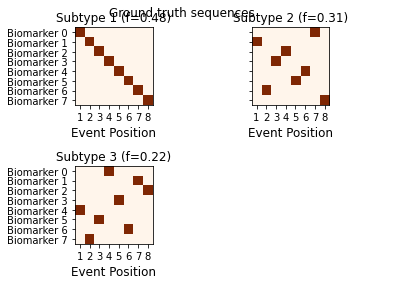

In [10]:
#ordering of positional variance diagrams (PVDs)
plot_subtype_order      = np.arange(N_S_ground_truth)
#ordering of biomarkers in each PVD
plot_biomarker_order    = ground_truth_sequences[plot_subtype_order[0], :].astype(int).ravel()
#plot PVDs given subtype and biomarker ordering
figs, ax                 = sustain._plot_sustain_model(ground_truth_sequences, ground_truth_fractions_actual, ground_truth_nsamples, \
                                                      subtype_order=plot_subtype_order, biomarker_order=plot_biomarker_order, title_font_size=12)
figs[0].suptitle('Ground truth sequences')
figs[0].savefig(os.path.join(output_folder, 'PVD_true.png'))
figs[0].show()

Failed to find pickle file: /home2/rtandon32/ebm/pySuStaIn/notebooks/sim7_mixture_GMM/pickle_files/sim7_subtype0.pickle. Running SuStaIn model for 0 subtype.
Finding ML solution to 1 cluster problem


AttributeError: 'MixtureSustainData' object has no attribute 'stage_size'

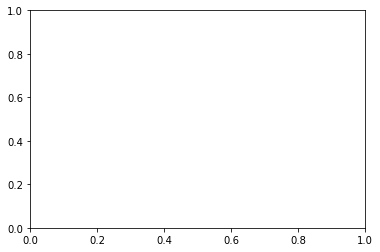

In [11]:
samples_sequence,   \
samples_f,          \
ml_subtype,         \
prob_ml_subtype,    \
ml_stage,           \
prob_ml_stage,      \
prob_subtype_stage      = sustain.run_sustain_algorithm(plot=True)